In [58]:
# Note to self: this site has dmv data uploaded routinely for EVs...
# https://www.atlasevhub.com/materials/state-ev-registration-data/#data
# lil sometin' for the future.
# the future is now.

# THE USUAL
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import time 
import os
import pytensor

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

# MODELS
from sklearn.ensemble import RandomForestRegressor 
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression
from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

import statsmodels.api as sm
import pystan
import pymc as pm
import arviz as az
import xarray as xr
from scipy.special import expit as logistic
import pytensor.tensor as pt

import os
# FOR THOSE PESKY WARNINGS
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [59]:
os.environ["PATH"] += os.pathsep + "⁨iCloud Drive⁩/⁨Desktop⁩/Programming⁩/⁨Python⁩/⁨PowerSupply⁩/Graphviz/bin"



In [60]:
# az.style.use("arviz-darkgrid")
RANDOM_SEED = 42 # the answer to life's great question
rng = np.random.default_rng(RANDOM_SEED)

In [61]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


In [62]:
census_key = '99571ba68d166cc2d9a35c8899f4c3244943b725' # hide this...

# SOURCE:
# https://github.com/fonnesbeck/hierarchical_models_sports_analytics/blob/main/Hierarchical_Models_Sports_Analytics.ipynb
# https://avehtari.github.io/ROS-Examples/

# LIST OF CENSUS VARIABLES:
# https://api.census.gov/data/2020/dec/dp/groups/DP1.html
# https://api.census.gov/data/2020/dec/dp/variables.html

## The focus of this whole charade!
- play with some open access data
- build some models
- make something hierarchical
- enjoy the fun of Bayes
- excuse to watch "Shogun" on Hulu while sampling

## FUNCTIONS

In [5]:
def census_scrub(raw):
    raw.columns = ['pct_car_buyers','car_buyers','pct_boomers','boomers','Under 5',
       '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years',
       '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years',
       '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years',
       '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years',
       '+85 years', 'zip', 'median_hh_inc']
    
    raw.zip = raw.zip.astype('int')
    raw.car_buyers = raw.car_buyers.astype('int')
    raw.boomers = raw.boomers.astype('int')
    raw.median_hh_inc = raw.median_hh_inc.astype('int')
    
    raw = raw[raw.median_hh_inc > 0].reset_index(drop=True) # remove bad values
    raw['inc_norm'] = (raw.median_hh_inc - np.mean(raw.median_hh_inc))/(np.std(raw.median_hh_inc))
    
    return raw
    
def dmv_clean(raw):
    
    df = raw.copy(deep=True)
    df.columns = ['state','zip','registration','make','model','year','ev_type',
                  'class','cat','count','id','version_date','latest','country']
    df.registration = pd.to_datetime(df.registration)
    
    df.version_date = df.version_date.str.extract('.*\((.*)\).*')
    df.version_date = pd.to_datetime(df.version_date)
    
    df = df[df.latest == True].reset_index(drop=True)
    df = df[df.zip != 'Error']
    df.zip = df.zip.astype('int')
    
    # index States
    state_idx = pd.DataFrame(zip
                         (set(df.state),
                          np.arange(0,len(set(df.state)))),
                          columns=['state','state_num'])
#     state_idx = pd.DataFrame(zip(unique_states,np.arange(0,len(unique_states))),columns=['state','state_num'])
    df = df.merge(state_idx)
    
#     df_g = df.groupby(['zip','state_num'],as_index=False).agg(ev=('count','sum'))
    df_g = df.groupby(['zip','state_num'],as_index=False).agg(ev=('count','sum'))
    
    return df, df_g

def put_it_together(d,c,threshold=.02):
    join = d.merge(c)
    join = join[join.median_hh_inc > 0].reset_index(drop=True)

    join['boomer_saturation'] = join.boomers/join.car_buyers
    join['ev_per_c'] = join.ev/join.car_buyers
    join['ev_per_1k_b'] = join.ev/(1+join.boomers)*1000
    
    join['ev_saturation'] = join['ev_per_c'].apply(lambda x: 1 if x >= threshold else 0) # need to account for number of people...
    
    join = join[join.ev_per_c < 1]
    join_f = join.drop(['zip'], axis=1).astype('float')
    join_f['zip'] = join.zip
    
    df = join_f
    df['kids'] = (100 - df.pct_car_buyers) / 100
    df['20s'] = (df['20 to 24 years'] + df['25 to 29 years']) / 100
    df['30s'] = (df['30 to 34 years'] + df['35 to 39 years']) / 100
    df['40s'] = (df['40 to 44 years'] + df['45 to 49 years']) / 100
    df['50s'] = (df['50 to 54 years'] + df['55 to 59 years']) / 100
    df['60s'] = (df['60 to 64 years'] + df['65 to 69 years']) / 100
    df['70s'] = (df['70 to 74 years'] + df['75 to 79 years']) / 100
    df['80s'] = (df['80 to 84 years'] + df['+85 years']) / 100
#     df['boomers'] = (df['60s'] + df['70s'])/100

#     df['inc_norm'] = (df.median_hh_inc - np.mean(df.median_hh_inc))/(np.std(df.median_hh_inc))

    return df

## PULL IN THE DATA

In [6]:
# Specify the base URL for the Census API (2020 Census)
base_url = 'https://api.census.gov/data/2020/acs/acs5/profile'

# Specify the variables you want to retrieve (e.g., median household income)
variables = {
    'get': 'DP03_0062E',  # Median household income
    'for': 'zip code tabulation area:*',
}

# Add your API key to the request
variables['key'] = census_key

# Make the API request
response = requests.get(base_url, params=variables)

if response.status_code == 200:
    print(response)

    x = response.json()
    data = x[1:]
    inc = pd.DataFrame(data, columns=['median_hh_inc','zip'])

<Response [200]>


In [7]:
base_url = 'https://api.census.gov/data/2020/dec/dp'

# Get population data for all zip codes
variables = ['DP1_0022P', # Percent - 21 years and over
             'DP1_0022C', # Count - 21 years and over
             'DP1_0023P', # Percent - 62 years and over
             'DP1_0023C', # Count - 62 years and over
             'DP1_0002P', # Under 5
             'DP1_0003P', # 5 to 9 years
             'DP1_0004P', # 10 to 14 years
             'DP1_0005P', # 15 to 19 years
             'DP1_0006P', # 20 to 24 years
             'DP1_0007P', # 25 to 29 years
             'DP1_0008P', # 30 to 34 years
             'DP1_0009P', # 35 to 39 years
             'DP1_0010P', # 40 to 44 years
             'DP1_0011P', # 45 to 49 years
             'DP1_0012P', # 50 to 54 years
             'DP1_0013P', # 55 to 59 years
             'DP1_0014P', # 60 to 64 years
             'DP1_0015P', # 65 to 69 years
             'DP1_0016P', # 70 to 74 years
             'DP1_0017P', # 75 to 79 years
             'DP1_0018P', # 80 to 84 years
             'DP1_0019P', # +85 years
            ]

geography = 'zip code tabulation area:*'

# Construct the API request URL
url = f'{base_url}?get={",".join(variables)}&for={geography}&key={census_key}'

response = requests.get(url) # Make the API request

if response.status_code == 200:
    print(response)
    
    x = response.json()
    data = x[1:]
    age = pd.DataFrame(data, columns=['above_21_pct',
        'above_21',
        'above_62_pct',
        'above_62',
        'Under 5',
        '5 to 9 years',
        '10 to 14 years',
        '15 to 19 years',
        '20 to 24 years',
        '25 to 29 years',
        '30 to 34 years',
        '35 to 39 years',
        '40 to 44 years',
        '45 to 49 years',
        '50 to 54 years',
        '55 to 59 years',
        '60 to 64 years',
        '65 to 69 years',
        '70 to 74 years',
        '75 to 79 years',
        '80 to 84 years',
        '+85 years',
        'zip'])

<Response [200]>


In [8]:
census = age.merge(inc) # JOIN 'EM

In [9]:
# Define the path to the subfolder
subfolder_path = 'data/dmv'

# List all files in the subfolder
file_list = os.listdir(subfolder_path)

# Filter out only files (not directories)
file_list = [file for file in file_list if os.path.isfile(os.path.join(subfolder_path, file))]
dmv_list = []

# Now, you can loop through the files and read their content, for example:
for file_name in file_list:
    if file_name != '.DS_Store': 
        print(file_name)
        file_path = os.path.join(subfolder_path, file_name)
        dmv_list.append(pd.read_csv(file_path))
        
dmv = pd.concat(dmv_list)
dmv = dmv[~dmv['ZIP Code'].isnull()]

.TX_EV_Registrations.csv.icloud


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd3 in position 8: invalid continuation byte

In [136]:
# Chapter 13: https://users.aalto.fi/~ave/ROS.pdf
# DS1 LEC27

## THE BAR IS LOW: 2%!

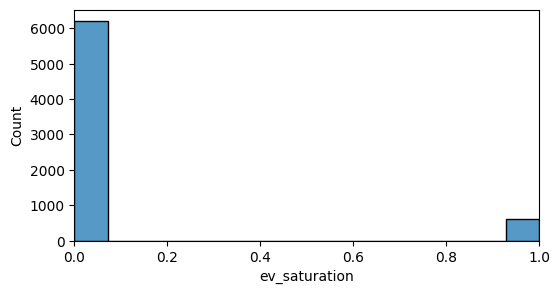

In [63]:
try:
    df = pd.read_csv('data/dc_final.csv')
except:
    c = census_scrub(census)
    d, d_g = dmv_clean(dmv)
    df = put_it_together(d_g,c,threshold=.02)

plt.figure(figsize=(6,3))
plt.xlim(0,1)
sns.histplot(df.ev_saturation);

In [64]:
df.columns

Index(['Unnamed: 0', 'state_num', 'ev', 'pct_car_buyers', 'car_buyers',
       'pct_boomers', 'boomers', 'Under 5', '5 to 9 years', '10 to 14 years',
       '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years',
       '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years',
       '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years',
       '75 to 79 years', '80 to 84 years', '+85 years', 'median_hh_inc',
       'inc_norm', 'boomer_saturation', 'ev_per_c', 'ev_per_1k_b',
       'ev_saturation', 'zip', 'kids', '20s', '30s', '40s', '50s', '60s',
       '70s', '80s'],
      dtype='object')

## FEATURE IMPORTANCE

It's sometimes helpful to just do a quick look into what variables are important when trying to predict the dependent variable, number of EVs per capita. We'll use a randome forest with a depth of 4 to understand what's going on. This is a great way to quickly assess what varaibles (or features) to include as we look at the models we want to use ahead.

fit_score: 0.4007123551806272


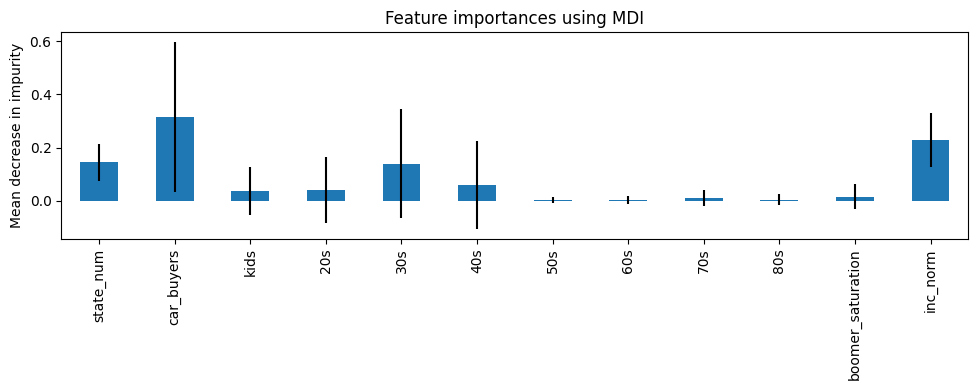

In [65]:
X = df[['state_num','car_buyers','kids','20s','30s','40s','50s','60s','70s','80s','boomer_saturation','inc_norm']]
y = df.ev_per_c #df.ev_saturation.astype('float')

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestRegressor(max_depth=4, random_state=0)
forest.fit(X, y)

print('fit_score:',forest.score(X, y, sample_weight=None))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(10,4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [66]:
y_ev = df.ev_saturation
x = df[['kids','20s','30s','40s','50s','boomer_saturation','inc_norm']]

x.shape, y_ev.shape, np.unique(y_ev)

((6834, 7), (6834,), array([0., 1.]))

### Income, Age, and EV Saturation (0 is <2%, 1 is >=2%)

Trying to come up with a way to visually show the different Age Distributions and the effect of income relative to areas that have reached a 2% saturation of electric vehicles per capita, which is admitedly a very low bar!

Not to get off topic, but the fat tailed income distribution is way more noticable than I'd have expected, speaking to the degree of income inequality we are seeing today in the US. I believe 250,000 is the upper limit for the U.S. 2020 Census data, so that is a data point that should have greater disbursement abscent the census limit.

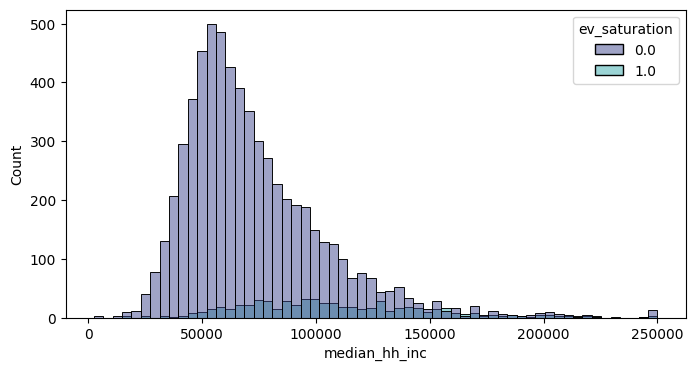

In [67]:
plt.figure(figsize=(8,4))
sns.histplot(x="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette="mako");

OK, cool. So we saw above the interplay between income and EV saturation... can we extend this to age demographics? This is where squinting helps to see some trends and it gives justification to further exploration through the powers of modeling! 

## AGE + MONEY + EV

One way to read this graph is to ask how well does the greenish-blue puddle cover the purple? 

In other words, are there any outliers when considering EV saturation for a certain Age group? A jut out on the top and bottom shows an income disparity (low income = less EV saturation) while one to the left and right shows the age demographic has a relationship on EV saturation.

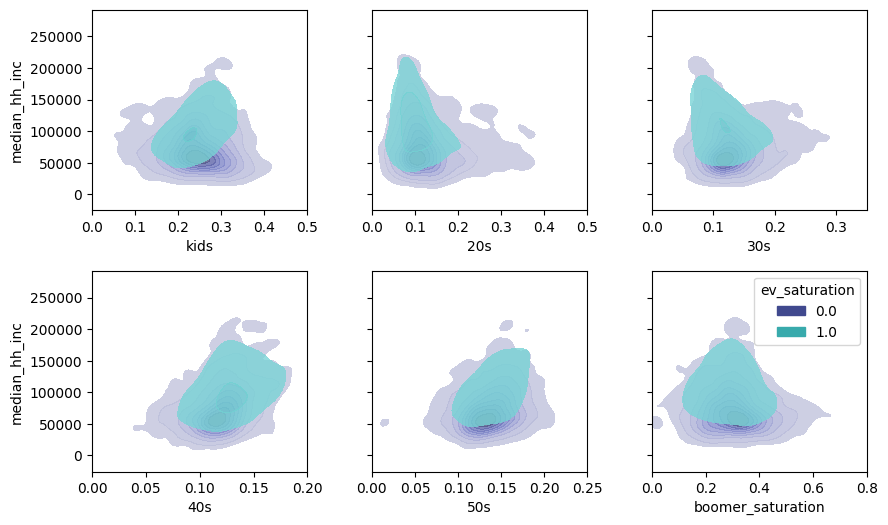

In [68]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize = (10,6),sharey=True,sharex=False)
fig.patch.set_alpha(0) # make transparent

super_cool_palette = sns.color_palette("mako", 2)#[::-1]

sns.kdeplot(x="kids", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette,ax=ax1,alpha=.8)
sns.kdeplot(x="20s", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette, ax=ax2,alpha=.8)
sns.kdeplot(x="30s", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette, ax=ax3,alpha=.8)
sns.kdeplot(x="40s", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette, ax=ax4,alpha=.8)
sns.kdeplot(x="50s", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette, ax=ax5,alpha=.8)
sns.kdeplot(x="boomer_saturation", y="median_hh_inc", data=df, hue="ev_saturation", fill=True, palette=super_cool_palette,ax=ax6,alpha=.8)

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
# ax6.get_legend().remove()

ax1.set_xlim(0, .5)
ax2.set_xlim(0, .5)
ax3.set_xlim(0, .35)
ax4.set_xlim(0, .2)
ax5.set_xlim(0, .25)
ax6.set_xlim(0, .8) # make way for boomtown

plt.subplots_adjust(wspace=0.3, hspace=0.3);

Alright, enough speculating on what the data shows based on visual squinting and finger measuring... Let's dive into the world of modeling and see what we can find out through regression!

Below you'll see that I've taken a Bayesian approach to understanding the relationships discussed above. The reasons for choosing this framework are...

- Great flexibility to quickly and iteratively build statistical models
- Offers kick-ass way of dealing with uncertainty
- Don't just want most likely outcome but distribution of all possible outcomes
- Allows expert information to guide model by using informative priors (if possible)
- Hierarchical modeling is great when impactful grouping exists


## MODEL 1: LOGISTIC (Full Pooling)


In [7]:
# labels = ["Intercept","20s","30s","40s","50s","boomer_saturation","inc_norm"]
labels = ["20s","30s","40s","50s","boomer_saturation","inc_norm"]
# df["Intercept"] = np.ones(len(df))

# reorder columns to be in the same order as labels
coords = {"coeffs": labels}
logit_df = df[labels]
x = logit_df.to_numpy()
s = df['state_num']
y = df['ev_saturation']

### PRIOR PREDICTIVE CHECK

INFO:pymc.sampling.forward:Sampling: [α, β]


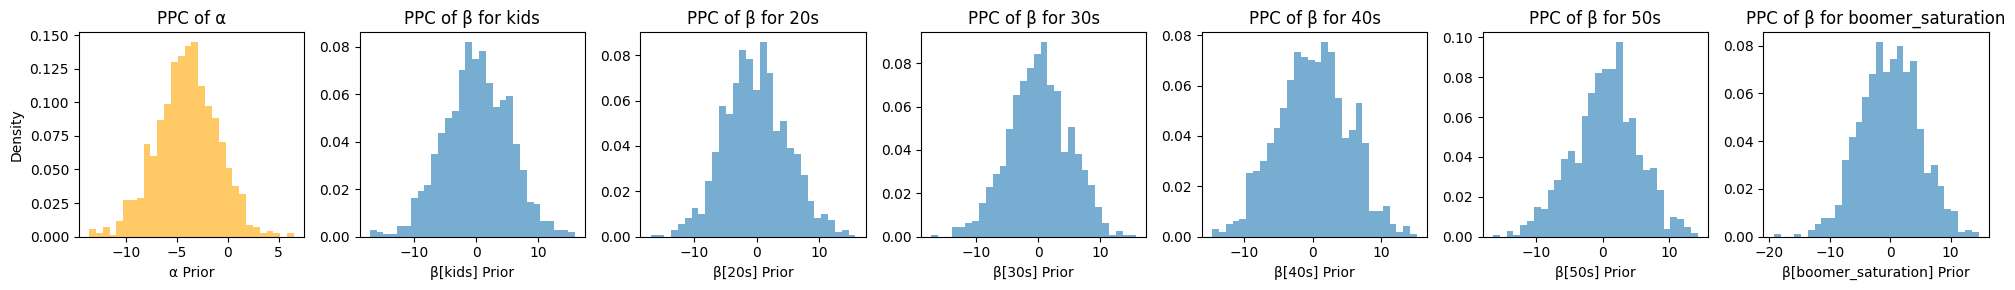

In [69]:
with pm.Model(coords=coords) as model:
    
    # priors    
    α = pm.Normal("α", mu=-4, sigma=3)
    β = pm.Normal("β", mu=0, sigma=5, dims="coeffs")
    prior_checks = pm.sample_prior_predictive(samples = 1000)

fig, axs = plt.subplots(1, len(labels)+1, figsize=(20, 3))
axs[0].hist(prior_checks.prior['α'][0], bins=30, density=True, alpha=0.6, color='orange')
axs[0].set_title('PPC of α')
axs[0].set_xlabel('α Prior')

for i in range(len(labels)):
    axs[i+1].hist(prior_checks.prior['β'][0][:, i], bins=30, density=True, alpha=0.6)
    axs[i+1].set_title(f'PPC of β for {labels[i]}')
    axs[i+1].set_xlabel(f'β[{labels[i]}] Prior')

axs[0].set_ylabel('Density')
plt.tight_layout()
plt.show()

### LOGISTIC MODEL

In [16]:
coords = {"coeffs": labels}

with pm.Model(coords=coords) as simple_model:
    # data containers
    X_mod = pm.MutableData("X", x)
    y_mod = pm.MutableData("y", y)
    
    # priors
    α = pm.Normal("α", mu=-5, sigma=3)
    β = pm.Normal("β", mu=0, sigma=5, dims="coeffs")
#     β = pm.Uniform("β", lower=-10,upper=10,dims="coeffs")
    
    # linear model
    μ = α + pm.math.dot(X_mod, β)
    
    # link function
    θ = pm.Deterministic("θ", pm.math.invlogit(μ))
    
    # likelihood
    y_hat = pm.Bernoulli("y_hat", p=θ, observed=y_mod)
    
    simple_trace = pm.sample(100, tune=100, cores=2, random_seed=RANDOM_SEED)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc.sampling.mcmc:NUTS: [α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


INFO:pymc.sampling.mcmc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 83 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [10]:
# pm.model_to_graphviz(simple_model)

In [170]:
with simple_model:
    pm.sample_posterior_predictive(simple_trace, extend_inferencedata=True)

INFO:pymc.sampling.forward:Sampling: [y_hat]


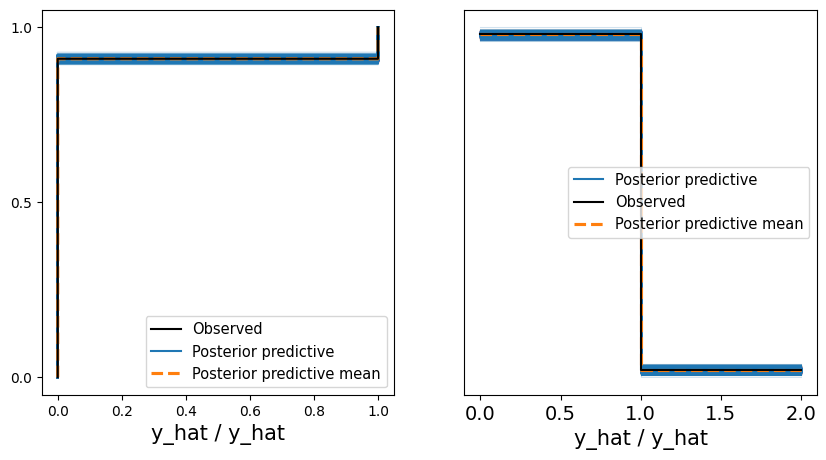

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(simple_trace, group='posterior', kind='cumulative', ax=axes[0]);
az.plot_ppc(simple_trace, group='posterior', ax=axes[1]);

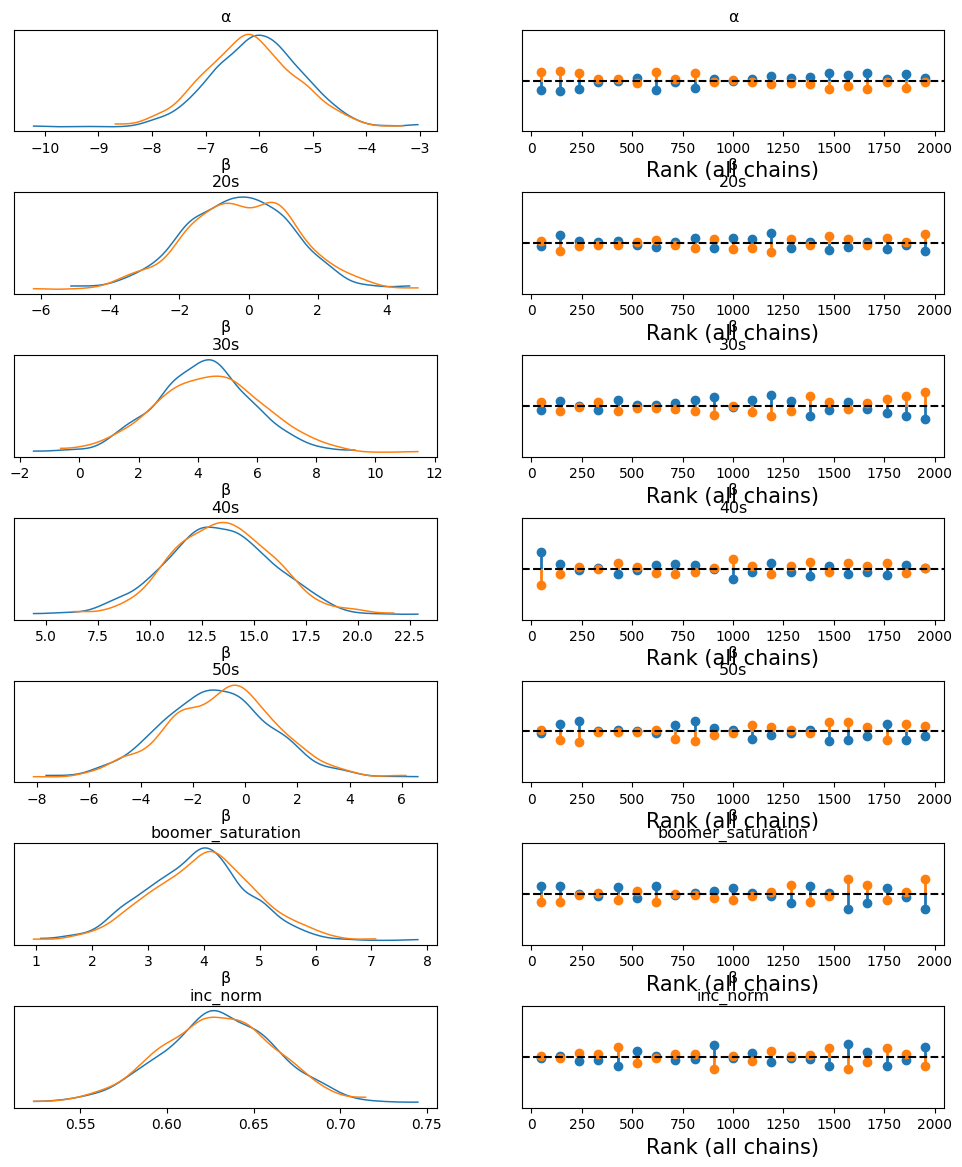

In [139]:
az.plot_trace(trace, var_names=["α","β"], compact=False,kind="rank_vlines")
plt.subplots_adjust(wspace=0.2, hspace=0.6);

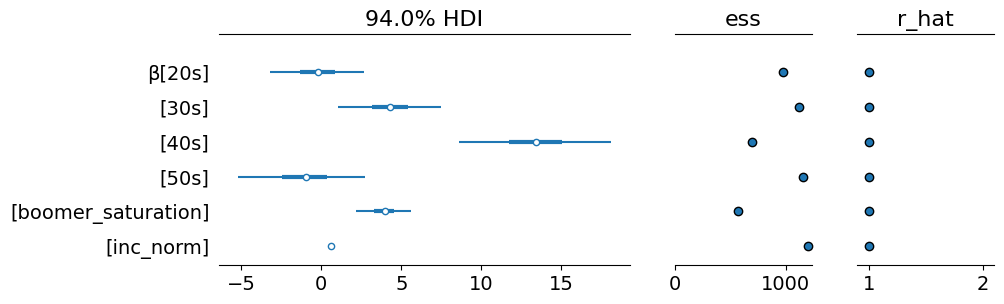

In [148]:
ax = az.plot_forest(
    trace,
    combined=True,
    hdi_prob=0.94,
    var_names=["β"],
    figsize=(10, 3),
    ess=True,
    r_hat=True,
#     backend="bokeh",
)

In [150]:
az.summary(trace, var_names=["α","β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-6.108,0.841,-7.635,-4.519,0.036,0.026,539.0,836.0,1.01
β[20s],-0.231,1.581,-3.202,2.697,0.051,0.036,971.0,1377.0,1.00
β[30s],4.296,1.717,1.030,7.490,0.051,0.037,1141.0,1020.0,1.00
β[40s],13.438,2.518,8.633,18.100,0.095,0.068,697.0,1161.0,1.01
β[50s],-1.003,2.113,-5.219,2.725,0.062,0.050,1166.0,1163.0,1.00
β[boomer_saturation],3.935,0.924,2.150,5.614,0.038,0.027,581.0,965.0,1.01
β[inc_norm],0.629,0.033,0.567,0.690,0.001,0.001,1216.0,1207.0,1.00


## MODEL 2: Linear Money-Model

In [35]:
labels = ["kids","20s","30s","40s","50s","boomer_saturation"]

# reorder columns to be in the same order as labels
coords = {"coeffs": labels}
money_df = df[labels].astype(float) # refactor to 1-0
x = money_df.to_numpy()
y = df.inc_norm

In [47]:
with pm.Model(coords=coords) as money_model:
    # data containers
    X_mod = pm.MutableData("X", x)
    y_mod = pm.MutableData("y", y)
    
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=5, dims="coeffs")
    
    # linear model
    μ = α + pm.math.dot(X_mod, β)
    likelihood = pm.Normal("y_hat", mu=μ, sigma=sigma, observed=y)
    
    trace = pm.sample(1000, tune=2000, cores=4, random_seed=RANDOM_SEED)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [sigma, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 782 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


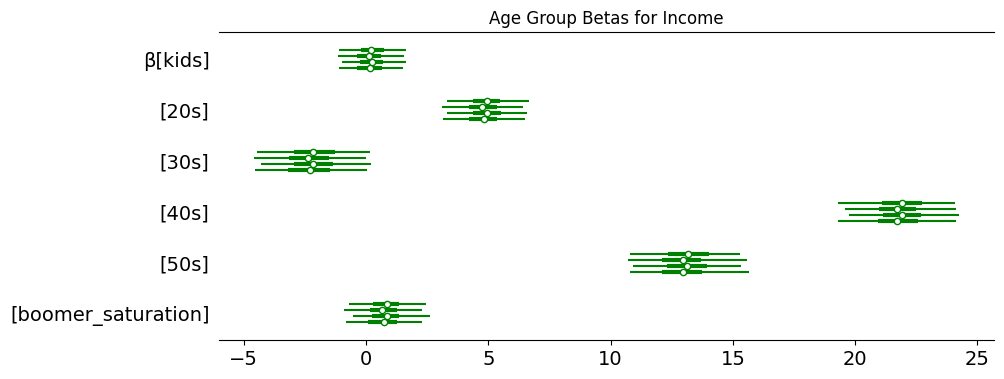

In [55]:
axes = az.plot_forest(trace, var_names=["β"], combined=False, hdi_prob=0.95, colors = 'green',r_hat=False, figsize=(10,4))
axes[0].set_title('Age Group Betas for Income');

Text(0.5, 1.0, 'Estimated Betas for Age Groups')

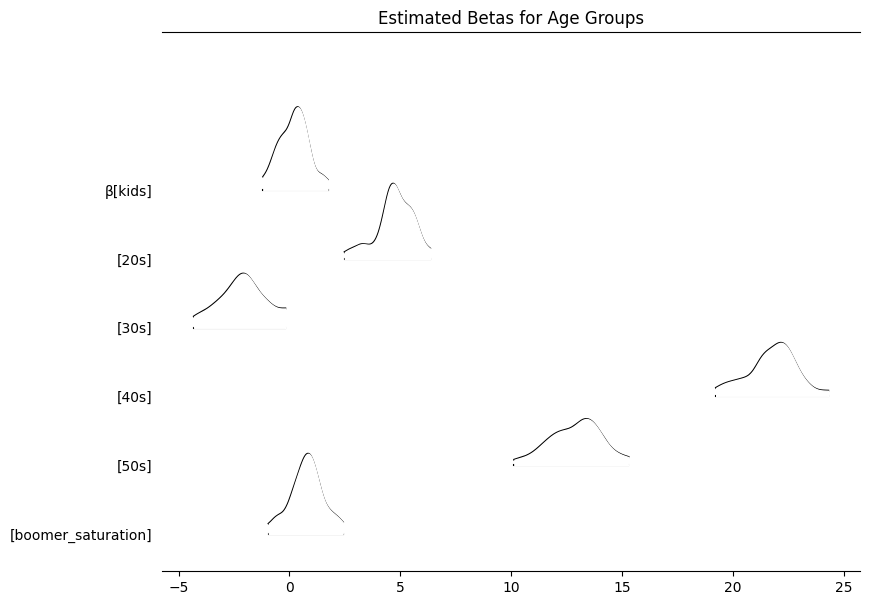

In [42]:
axes = az.plot_forest(trace,
                           kind='ridgeplot',
                           var_names=['β'],
                           combined=True,
                           ridgeplot_overlap=3,
                           colors='white',
                           figsize=(9, 7))
axes[0].set_title('Estimated Betas for Age Groups')

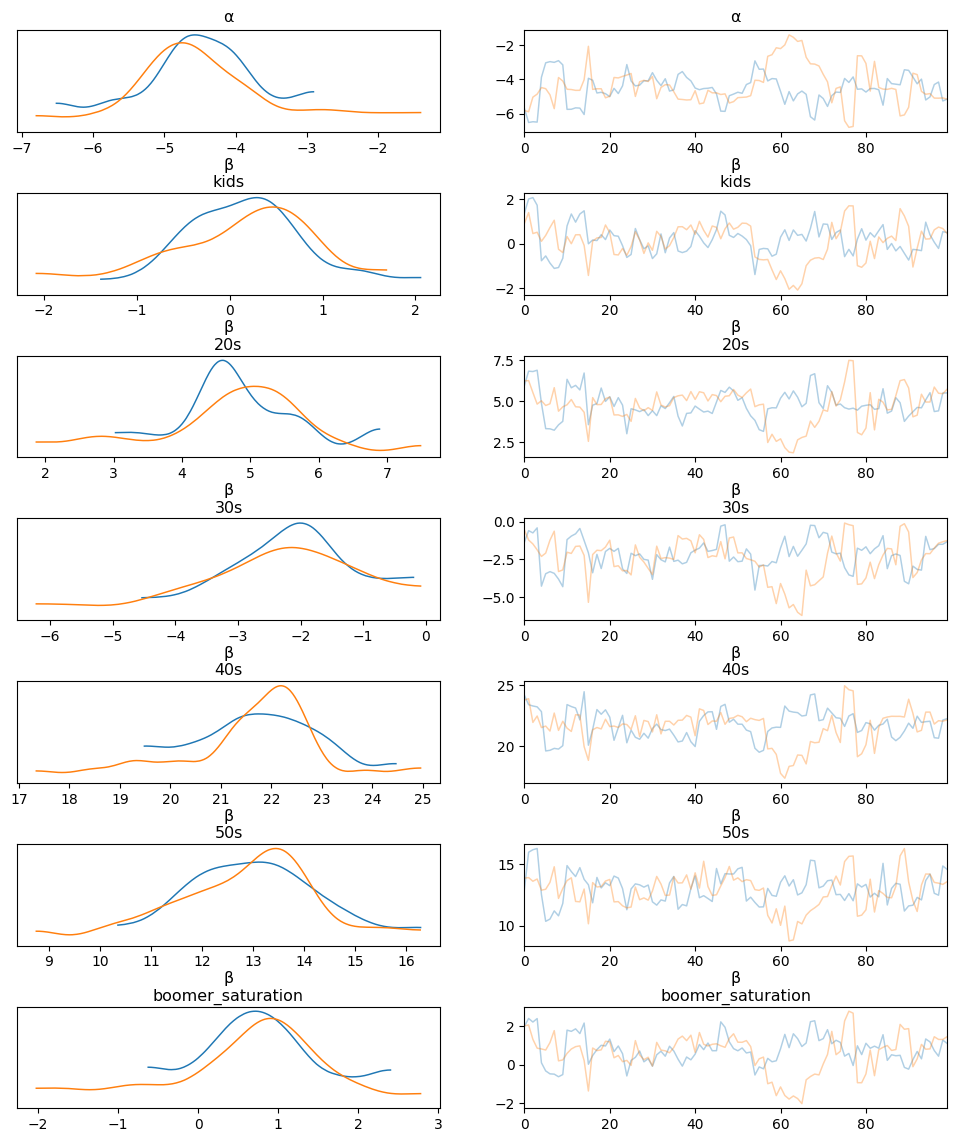

In [162]:
az.plot_trace(trace, var_names=["α","β"], compact=False);
plt.subplots_adjust(wspace=0.2, hspace=0.6);


# MODEL 3: HIERARCHICAL LOGISTIC (Pooling)


In [65]:
# use same priors
# implement hierarchy on state
# consider county hierarchy or state-county two tiers

# Pair this model down and just do a single age variable... 

In [11]:
labels = ["20s","30s","40s","50s","boomer_saturation","median_hh_inc"]

# data stuffing
x = df[labels].to_numpy()
s = df['state_num'].astype('int')
y = df['ev_saturation'].astype('int').to_numpy()
group_indicator = s.to_numpy()

state_idx, s = df.state_num.factorize()
coords = {"metric": labels}
coords['state'] = s

# Set x and y
X_mean = df[labels].mean()
X_std = df[labels].std()

X = ((df[labels] - X_mean) / X_std).values
y = df.ev_saturation

,Unnamed: 0,state_num,ev,pct_car_buyers,car_buyers,pct_boomers,boomers,Under 5,5 to 9 years,10 to 14 years,...,ev_saturation,zip,kids,20s,30s,40s,50s,60s,70s,80s
0,0,7.0,2.0,86.0,14506.0,30.5,5146.0,2.6,2.8,3.4,...,0.0,907,0.140,0.095,0.137,0.138,0.157,0.154,0.114,0.074
1,1,1.0,1.0,74.3,28392.0,21.8,8344.0,5.6,6.2,6.6,...,0.0,1040,0.257,0.129,0.137,0.114,0.130,0.116,0.074,0.053
2,2,6.0,1.0,77.1,1298.0,26.1,440.0,4.8,5.0,7.2,...,0.0,1081,0.229,0.085,0.127,0.120,0.148,0.167,0.088,0.041
3,3,6.0,1.0,75.6,11108.0,27.6,4050.0,4.3,5.8,6.6,...,0.0,1095,0.244,0.091,0.101,0.112,0.154,0.147,0.099,0.063
4,4,5.0,1.0,90.6,145.0,41.9,67.0,5.0,1.9,1.3,...,0.0,1258,0.094,0.088,0.081,0.101,0.206,0.207,0.157,0.069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,6829,7.0,1.0,71.3,15540.0,20.1,4377.0,4.9,7.3,7.8,...,0.0,99516,0.287,0.077,0.117,0.139,0.158,0.144,0.070,0.018
6830,6830,4.0,1.0,70.0,18860.0,13.7,3704.0,6.9,7.9,7.7,...,0.0,99577,0.300,0.125,0.171,0.131,0.121,0.101,0.047,0.012
6831,6831,7.0,1.0,77.7,185.0,28.6,68.0,8.4,4.2,5.9,...,0.0,99631,0.223,0.097,0.038,0.121,0.189,0.185,0.138,0.008
6832,6832,4.0,1.0,73.6,13508.0,17.4,3196.0,5.9,6.3,6.4,...,0.0,99701,0.264,0.184,0.156,0.105,0.109,0.107,0.058,0.035


In [12]:
with pm.Model(coords=coords) as state_covariate_model:

    m_mu = pm.Normal('m_mu', mu=0, sigma=10)
    s_mu = pm.HalfNormal('s_mu', 5)
    mu = pm.Normal('mu', mu=m_mu, sigma=s_mu, dims='state')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='state')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims = 'state')

    beta = pm.Normal('beta', mu=0, sigma=1, dims='metric')

    logit_p = pm.Deterministic('logit_p',
        mu[state_idx] + theta[state_idx] + epsilon[state_idx] + beta.dot(X.T),
    )
    
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    
    y_hat = pm.Bernoulli("y_hat", p=p, observed=y)


In [13]:
pm.model_to_graphviz(state_covariate_model)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [15]:
with state_covariate_model:
    individual_covariate_trace = pm.sample(1000, tune=2000, chains=4, cores=4, random_seed=42)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [m_mu, s_mu, mu, theta, sigma, epsilon, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 718 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

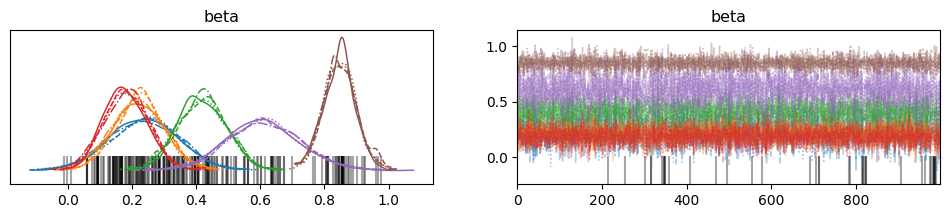

In [30]:
az.plot_trace(individual_covariate_trace, var_names=['beta'])

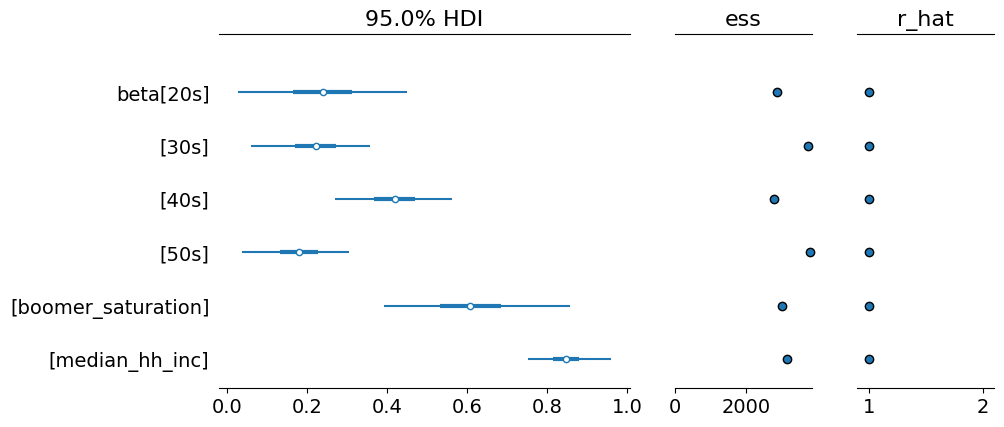

In [32]:
az.plot_forest(individual_covariate_trace, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True, ess=True);


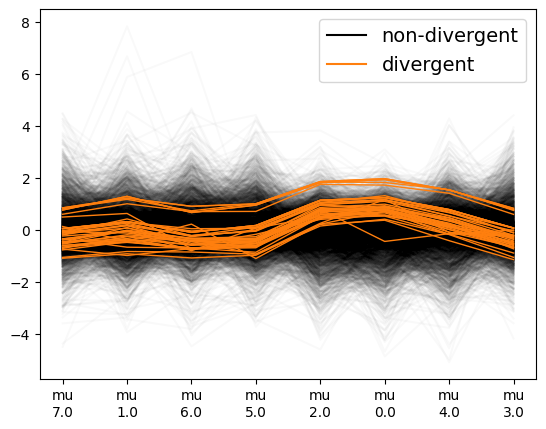

In [164]:
az.plot_parallel(individual_covariate_trace, var_names=["mu"], norm_method="normal");

### Mostly Garbage-Land

In [27]:
state_idx, state = df.state_num.factorize()

In [28]:
with pm.Model(coords = coords) as hierarchical_model:
    
    m_mu = pm.Normal('mmu',mu=0,sigma=5)
    s_mu = pm.HalfNormal('s_mu',1)
    mu = pm.Normal('mu', mu = m_mu, sigma = s_mu, dims = 'state')
    
#     theta = pm.ZeroSumNormal('theta', sigma = 1, dims = '')
    # Individual random effects
    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma = sigma, dims = 'coeffs')
    
    p = pm.Deterministic('p', pm.math.invlogit(mu[state_idx] + epsilon['coeffs']))
    
    y = pm.Binomial('y', p=p, observed = y, dims = 'coeffs')


RecursionError: maximum recursion depth exceeded in comparison

In [16]:
with pm.Model(coords = coords) as h_model:
    # Priors for fixed effects coefficients
    β = pm.Normal('β', mu=0, sigma=5, shape=(len(labels)),dims="coeffs")

    # Priors for group-level effects coefficients
    β_group = pm.Normal('β_group', mu=0, sigma=5, shape=(n_groups, len(labels)))

    # Group-level effects
    group_indicator_shared = pm.Data("shared", group_indicator)
    group_effects = pm.Deterministic('group_effects', β_group[group_indicator_shared])

    # Logit-linear model
    μ = pm.math.dot(x, β) + group_effects
#     p = pm.math.invlogit(mu)
    p = pm.Deterministic("θ", pm.math.invlogit(μ))
    
    # Likelihood
#     y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...


ValueError: Input dimension mismatch: (input[0].shape[1] = 6834, input[1].shape[1] = 6)
Apply node that caused the error: Composite{sigmoid((i0 + i1))}(ExpandDims{axis=0}.0, group_effects)
Toposort index: 6
Inputs types: [TensorType(float64, shape=(1, 6834)), TensorType(float64, shape=(None, None))]
Inputs shapes: [(1, 6834), (6834, 6)]
Inputs strides: [(54672, 8), (48, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [400]:
az.plot_forest(trace, var_names=["group_effects"], combined=True, hdi_prob=0.95, ess=True);

Error in callback <function _draw_all_if_interactive at 0x12bb52de0> (for post_execute):


ValueError: Image size of 800x410440 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 800x410440 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x410440 with 2 Axes>

In [330]:
x_flat = np.concatenate(x)
y_flat = y

n_features = 6
n_groups = len(set(s))

with pm.Model(coords = coords) as hierarchical_logistic_model:
    # Group-level priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    
    # Individual-level parameters
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_groups)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_groups)
    
    # Likelihood
    p = pm.invlogit(alpha + beta * x)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_flat)
    
    # Sample the model
    trace = pm.sample(2000, tune=1000, cores=1)  # Use more cores if available

ValueError: Incompatible Elemwise input shapes [(1, 8), (6834, 6)]

In [323]:
n_features = 6
n_groups = len(set(s))
# X = x

with pm.Model(coords = coords) as hierarchical_model:
    # Hyperparameters
    alpha_mu = pm.Normal('alpha_mu', mu=0, sigma=10)
    alpha_sigma = pm.HalfNormal('alpha_sigma', sigma=10)

    beta_group_mu = pm.Normal('beta_group_mu', mu=0, sigma=10, shape=n_features)
    beta_group_sigma = pm.HalfNormal('beta_group_sigma', sigma=10, shape=n_features)

    # Group level parameters
    alpha_group = pm.Normal('alpha_group', mu=alpha_mu, sigma=alpha_sigma, shape=n_groups)
    beta_group = pm.Normal('beta_group', mu=beta_group_mu, sigma=beta_group_sigma, shape=(n_groups, n_features))

    # Individual level parameters
    alpha = alpha_group[group_idx]
    beta = beta_group[group_idx]
    
    # Individual-level parameters
    alpha = pm.Normal('alpha', mu=alpha_mu, sd=alpha_sigma, shape=(N_samples_per_group, N_outcomes))
    beta = pm.Normal('beta', mu=mu_beta, sd=sigma_beta, shape=(N_samples_per_group, N_outcomes, N_predictors))

    # Logistic function
#     p = pm.math.invlogit(alpha[:, np.newaxis] + (X * beta[:, np.newaxis, :]).sum(axis=2))
#     p = pm.math.invlogit(alpha[:, np.newaxis] + (x * beta[:, np.newaxis, :]).sum(axis=2))

    # Likelihood
#     y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    # Likelihood
    p = pm.invlogit(alpha + pm.math.dot(X, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    # Sampling
    trace = pm.sample(1000, tune=1000, cores=1)

ValueError: Size length is incompatible with batched dimensions of parameter 0 Sigmoid.0:
len(size) = 1, len(batched dims Sigmoid.0) = 2. Size length must be 0 or >= 2

In [322]:
trace

Inference data with groups:
	> posterior
	> sample_stats

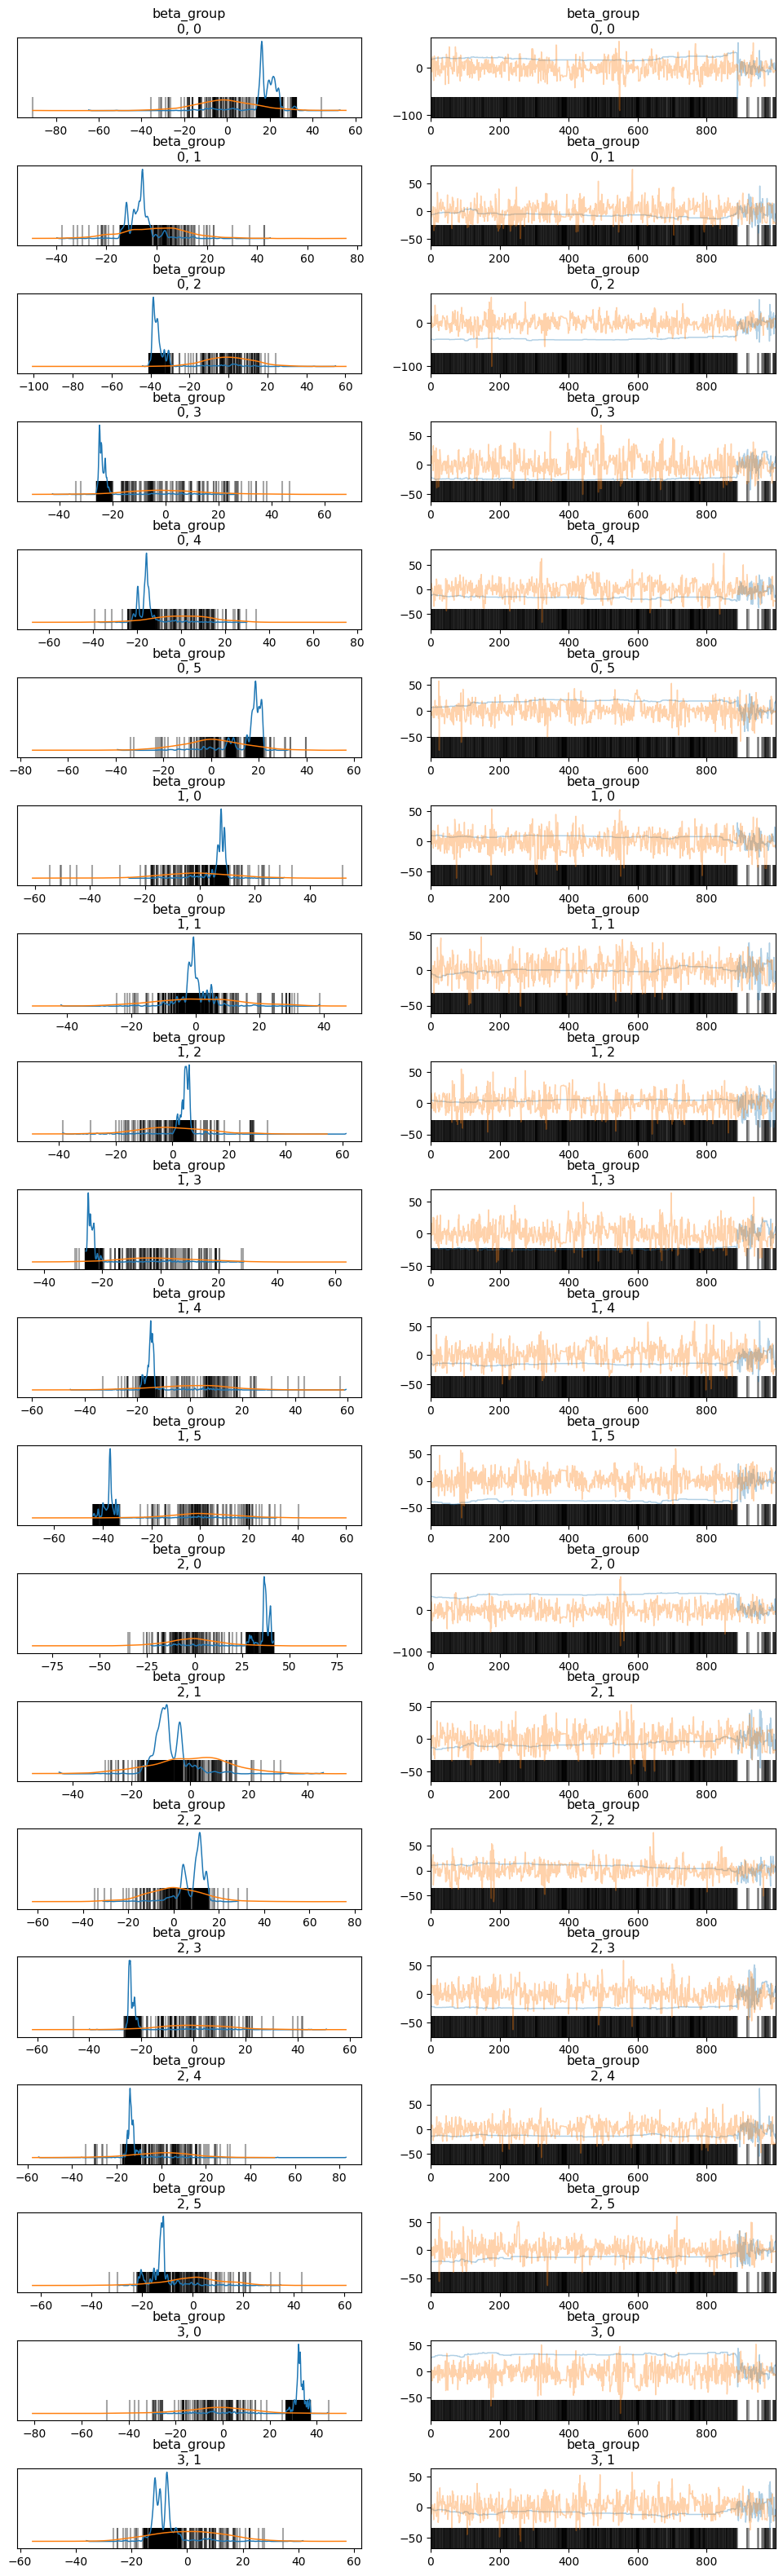

In [319]:
az.plot_trace(trace, var_names=["beta_group"], compact=False);
plt.subplots_adjust(wspace=0.2, hspace=0.6);

In [304]:
# FAKE DATA:
np.random.seed(123)
n_groups = 5
n_per_group = 100
n_total = n_groups * n_per_group

# Generate group indicators
group_idx = np.repeat(range(n_groups), n_per_group)

# True parameters
true_alpha = 1.0
true_beta_group = np.random.normal(0, 1, n_groups)
true_sigma_group = 1.0
true_beta_x1 = 0.5
true_beta_x2 = 2

# Generate predictors
x1 = np.random.normal(.3, .15, n_total)
x2 = np.random.normal(0, 1, n_total)

# Generate outcomes
true_p = np.exp(true_alpha + true_beta_group[group_idx] + true_beta_x1 * x1 + true_beta_x2 * x2) / \
         (1 + np.exp(true_alpha + true_beta_group[group_idx] + true_beta_x1 * x1 + true_beta_x2 * x2))
y = np.random.binomial(1, true_p, size=n_total)


In [77]:
labels = ["boomers","inc_norm"]
df_test = pd.DataFrame(zip(x1,x2),columns=labels)
x = df_test.to_numpy()

In [112]:
n_features = 2
n_groups = 5
X = x

with pm.Model() as hierarchical_model:
    # Hyperparameters
    alpha_mu = pm.Normal('alpha_mu', mu=0, sigma=10)
    alpha_sigma = pm.HalfNormal('alpha_sigma', sigma=10)

    beta_group_mu = pm.Normal('beta_group_mu', mu=0, sigma=10, shape=n_features)
    beta_group_sigma = pm.HalfNormal('beta_group_sigma', sigma=10, shape=n_features)

    # Group level parameters
    alpha_group = pm.Normal('alpha_group', mu=alpha_mu, sigma=alpha_sigma, shape=n_groups)
    beta_group = pm.Normal('beta_group', mu=beta_group_mu, sigma=beta_group_sigma, shape=(n_groups, n_features))

    # Individual level parameters
    alpha = alpha_group[group_idx]
    beta = beta_group[group_idx]

    # Logistic function
#     p = pm.math.invlogit(alpha[:, np.newaxis] + (X * beta[:, np.newaxis, :]).sum(axis=2))
    p = pm.math.invlogit(alpha[:, np.newaxis] + (X * beta[:, np.newaxis, :]).sum(axis=2))

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    # Sampling
    trace = pm.sample(1000, tune=1000, cores=1)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [alpha_mu, alpha_sigma, beta_group_mu, beta_group_sigma, alpha_group, beta_group]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [108]:
with pm.Model() as hierarchical_model:
    # data containers
    X_mod = pm.MutableData("X", x)
    y_mod = pm.MutableData("y", y)
    
    # priors
#     β = pm.Normal("β", mu=0, sigma=5, dims="coeffs")
    
    # state level priors
    α_state = pm.Normal('α_state', mu = 0, sigma=5, shape=n_groups)
#     β_state = pm.Normal('β_state',mu = 0, sigma=10, shape=n_groups, dims = "coeffs")
    β_state = pm.Normal('β_state',mu = 0, sigma=10, shape=(n_groups,2))
#     β = pm.Uniform("β", lower=-10,upper=10,dims="coeffs")
#     α = α_state[group_idx]
    
    # linear model
#     μ = α + pm.math.dot(X_mod, β_state[group_idx])
    μ = α_state[group_idx] + pm.math.dot(X_mod, β_state[group_idx])
    
    # link function
    θ = pm.Deterministic("θ", pm.math.invlogit(μ))
    
    # likelihood
    y_hat = pm.Bernoulli("y_hat", p=θ, observed=y_mod)
    
    # sampling
    trace = pm.sample(250, tune=500, cores=1, random_seed=1234)
    

ValueError: Size length is incompatible with batched dimensions of parameter 0 θ:
len(size) = 1, len(batched dims θ) = 2. Size length must be 0 or >= 2

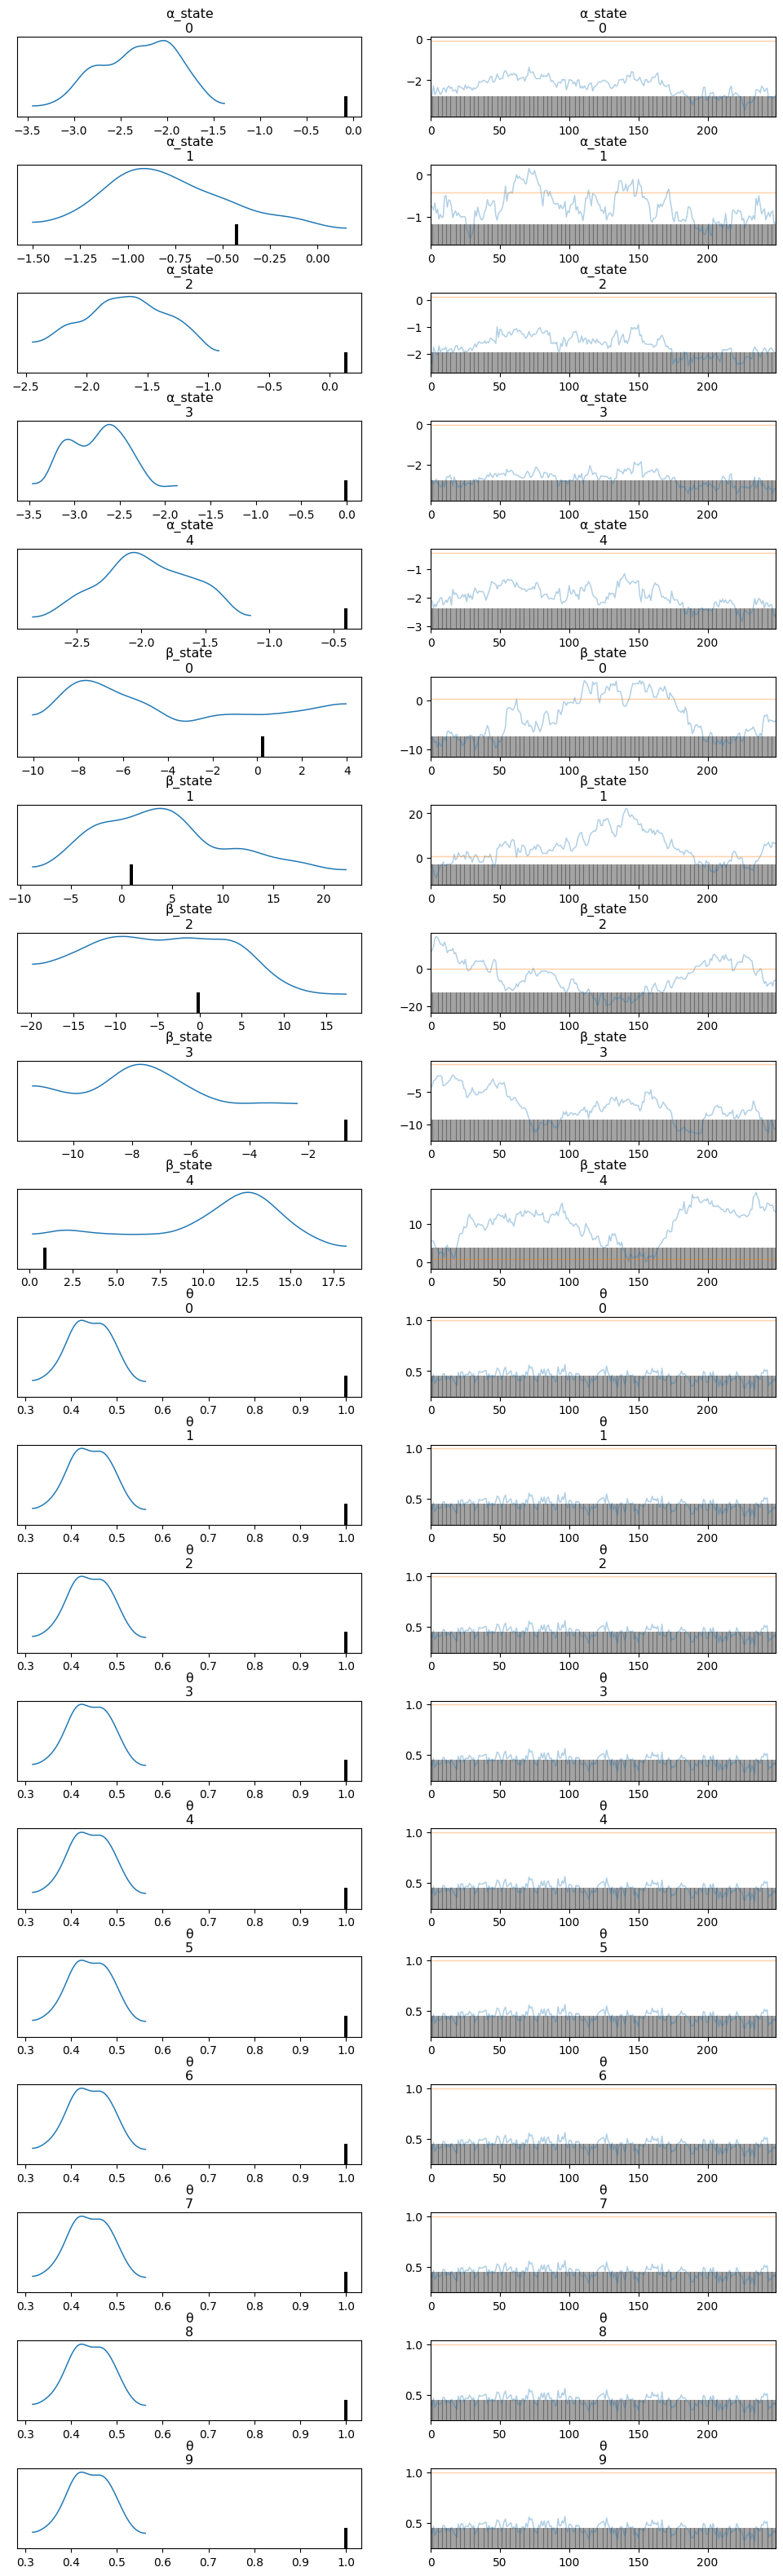

In [106]:
az.plot_trace(trace, compact=False);
plt.subplots_adjust(wspace=0.2, hspace=0.6);

## Generate Out-Of-Sample Predictions

In [80]:
with model:
    pm.set_data({"X": x_test, "y": y_test})
    trace.extend(pm.sample_posterior_predictive(trace))

INFO:pymc.sampling.forward:Sampling: [y_hat]


In [82]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = trace.posterior_predictive["y_hat"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()

print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")

accuracy =  0.777


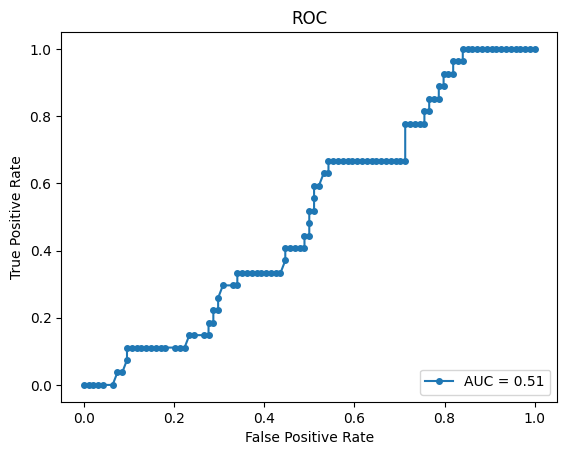

In [83]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

### Model Decision Boundary

In [103]:
x1_grid, x2_grid, x_grid = make_grid()

In [104]:
x_grid

array([[0.        , 0.        ],
       [0.00334448, 0.        ],
       [0.00668896, 0.        ],
       ...,
       [0.99331104, 1.        ],
       [0.99665552, 1.        ],
       [1.        , 1.        ]])

In [105]:
def make_grid():
    x1_grid = np.linspace(start=0, stop=1, num=300)
    x2_grid = x1_grid
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
    x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)
    return x1_grid, x2_grid, x_grid


x1_grid, x2_grid, x_grid = make_grid()

with model:
    # Create features on the grid.
    x_grid_ext = np.hstack(
        (
            np.ones((x_grid.shape[0], 1)),
            x_grid,
            (x_grid[:, 0] * x_grid[:, 1]).reshape(-1, 1),
        )
    )
    # set the observed variables
    pm.set_data({"X": x_grid_ext})
    # calculate pushforward values of `p`
    ppc_grid = pm.sample_posterior_predictive(trace, var_names=["p"])

Sampling: []


In [106]:
# grid of predictions
grid_df = pd.DataFrame(x_grid, columns=["x1", "x2"])
grid_df["p"] = ppc_grid.posterior_predictive.p.mean(dim=["chain", "draw"])
p_grid = grid_df.pivot(index="x2", columns="x1", values="p").to_numpy()

In [114]:
def calc_decision_boundary(trace, x1_grid):
    # posterior mean of coefficients
    intercept = trace.posterior["b"].sel(coeffs="Intercept").mean().data
    b1 = trace.posterior["b"].sel(coeffs="20s").mean().data
    b2 = trace.posterior["b"].sel(coeffs="boomer_saturation").mean().data
    b1b2 = trace.posterior["b"].sel(coeffs="inc_norm").mean().data
    # decision boundary equation
    return -(intercept + b1 * x1_grid) / (b2 + b1b2 * x1_grid)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


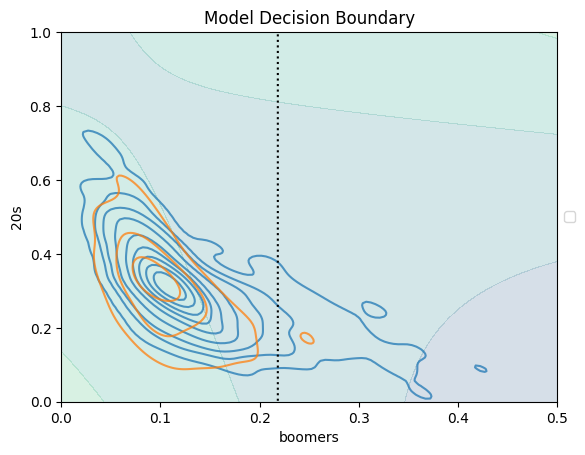

In [145]:
fig, ax = plt.subplots()

# data
sns.kdeplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    ax=ax,
    alpha=.75
)

# decision boundary
ax.plot(x1_grid, calc_decision_boundary(trace, x1_grid), color="black", linestyle=":")

# grid of predictions
ax.contourf(x1_grid, x2_grid, p_grid, alpha=0.2)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Model Decision Boundary", xlim=(0, .5), ylim=(0, 1), xlabel="boomers", ylabel="20s");


$$EVSat_i\sim \mathrm{Bernoulli}(\alpha_{\text{state}[i]} + \beta_{\text{state}[i]} A_i, \sigma)\qquad i=1,...,N$$

$$\alpha_j \sim \mathrm{Normal}(\bar{\alpha}, \sigma_\alpha)\qquad j=1,...,n_c$$
$$\beta_j \sim \mathrm{Normal}(\bar{\beta}, \sigma_\beta)\qquad j=1,...,n_c$$

$$\bar{\alpha} \sim\mathrm{Normal}(5, 2)$$
$$\bar{\beta} \sim\mathrm{Normal}(-1, 3)$$
$$\sigma_\alpha\sim\mathrm{Exponential}(1)$$
$$\sigma_\beta\sim\mathrm{Exponential}(1)$$

$$\sigma\sim\mathrm{Exponential}(1)$$

where $A_i=1$ if visit $i$ was during the afternoon.

In [132]:
with pm.Model(coords=coords) as model_h:

    # data containers
    X = pm.MutableData("X", x_train)
    y = pm.MutableData("y", y_train)
    s = pm.MutableData("s", s_train)
    
    # priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    
    # linear model
    mu = pm.math.dot(a,s) + pm.math.dot(X, b)
    
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
    

### PRIOR PREDICTIVE CHECK

In [127]:
x = df.boomer_saturation
y_ev = df.ev_saturation
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * x
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=y_ev)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


In [84]:
# Xt = pytensor.shared(df[['20s','30s','inc_norm']])
# yt = pytensor.shared(y_ev)

Xt = pytensor.shared(df[['20s','30s','inc_norm']].values)
yt = pytensor.shared(y_ev.values)

with pm.Model() as iris_model:
    # Coefficients for features
    β = pm.Normal("β", 0, sigma=1e2, shape=(3,))
    # Transoform to unit interval
    a = pm.Normal("a", sigma=1e4, shape=(3,))
    p = pt.special.softmax(Xt.dot(β) + a, axis=-1)

#     observed = pm.Categorical("obs", p=p, observed=yt)
    outcome = pm.Bernoulli("outcome", p=p, observed=yt)

In [46]:
outcomes = y_ev
predictors = df[['20s','30s','inc_norm']]

with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0.0, sigma=0.5)
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0, 1.0]), shape=3)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id", shape=3)
    p = pm.Deterministic("p", pm.math.invlogit(alpha + betas * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

TypeError: 'int' object is not iterable

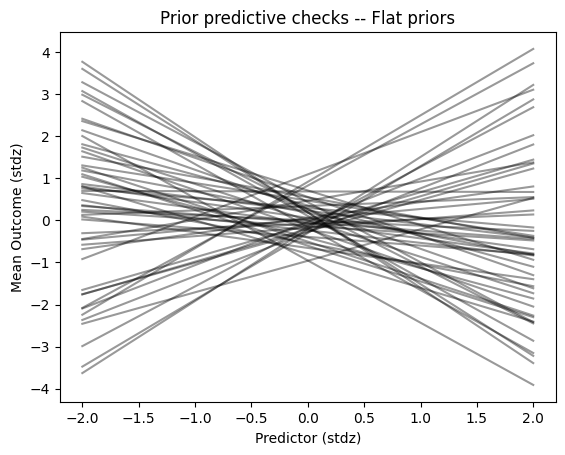

In [40]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

### RUN THE SIMPLE MODEL

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


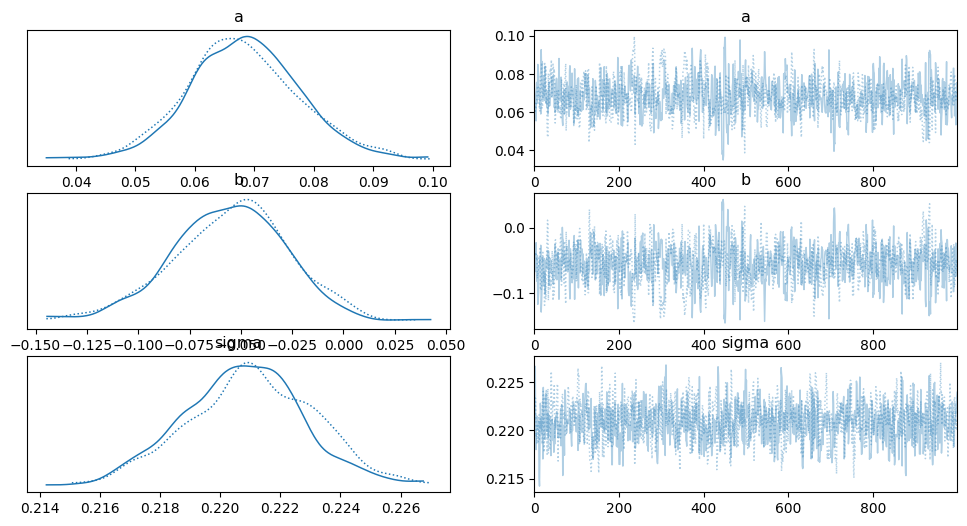

In [41]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [107]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)



with pm.Model() as model_simple:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=-10, sigma=1/0.1)
    mu = alpha + pm.math.dot(x, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    dec_bnd = pm.Deterministic('dec_bnd', -alpha/beta) # decision boundary
    y_1 = pm.Bernoulli('y_1', p=theta, observed=y)
    
    trace = pm.sample(1000, tune=1000)

NameError: name 'predictors' is not defined

In [93]:
iris = sns.load_dataset("iris")

y = pd.Categorical(iris["species"]).codes

x_n = iris.columns[:-1]
x_s = iris[x_n].values
x = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x.shape, y.shape, np.unique(y_s)

((150, 4), (150,), array([0, 1, 2], dtype=int8))

In [100]:


with pm.Model() as logistic_regression:
    # Priors
    beta = pm.Normal('beta', mu=np.zeros((7, 1)), tau=np.eye(p), shape=(7, 1))  # Coefficients
    intercept = pm.Normal('intercept', mu=0, tau=1, shape=m)  # Intercept
    
    # Logistic transformation
    theta = pm.math.dot(X, beta) + intercept
    p = pm.invlogit(theta)
    
    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)  # Likelihood

    # Sample posterior
    trace = pm.sample(1000, burn=500, thin=2)

# Summary of the model
pm.summary(trace)

NameError: name 'p' is not defined

In [101]:
# with pm.Model() as model_sf:
#     α = pm.Normal("α", mu=0.0, sigma=1.0, shape=1)
# #     α_f = tt.concatenate([[0], α])

#     β = pm.Normal("β", mu=0.0, sigma=0.5, shape=(4, 1))
# #     β_f = tt.concatenate([np.zeros((4, 1)), β], axis=1)

#     X = pm.Data("X", x)
#     μ = α + pm.math.dot(X, β)
# #     θ = pm.Deterministic("θ", tt.nnet.softmax(μ))
#     θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

# #     yl = pm.Categorical("yl", p=θ, observed=y_s)
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=y) 
    
#     trace_sf = pm.sample(1000, tune=2000, cores=2)#, random_seed=RANDOM_SEED)

# az.summary(trace_sf, round_to=2, var_names=["α", "β"])

## Multivariet LINEAR REGRESSION

In [21]:
X = df[['kids','20s','30s','40s','50s','pct_boomers','median_hh_inc']]
# X = X/100
x = X
#add constant to predictor variables
# x = sm.add_constant(X)
y = df['ev']
#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                     ev   R-squared (uncentered):                   0.219
Model:                            OLS   Adj. R-squared (uncentered):              0.218
Method:                 Least Squares   F-statistic:                              258.2
Date:                Sun, 28 Jan 2024   Prob (F-statistic):                        0.00
Time:                        20:25:34   Log-Likelihood:                         -43595.
No. Observations:                6451   AIC:                                  8.720e+04
Df Residuals:                    6444   BIC:                                  8.725e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [233]:
# building the model and fitting the data 
X = df[['kids','20s','30s','40s','50s','pct_boomers']]
y = df['ev_saturation']
log_reg = sm.Logit(y, X).fit() 

Optimization terminated successfully.
         Current function value: 0.528565
         Iterations 6


In [234]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:          ev_saturation   No. Observations:                 6451
Model:                          Logit   Df Residuals:                     6445
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Jan 2024   Pseudo R-squ.:                 0.03415
Time:                        23:59:37   Log-Likelihood:                -3409.8
converged:                       True   LL-Null:                       -3530.3
Covariance Type:            nonrobust   LLR p-value:                 4.369e-50
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
kids           -0.0685      0.006    -12.437      0.000      -0.079      -0.058
20s            -0.0248      0.009     -2.759      0.006      -0.042      -0.007
30s            -0.0601      0.012     -5.027    

In [236]:
df[df.zip == 10507]

,ev,pct_car_buyers,car_buyers,pct_boomers,boomers,Under 5,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,...,ev_per_1k_b,ev_saturation,zip,kids,20s,30s,40s,50s,60s,70s
1247,39.0,76.2,4971.0,18.0,1173.0,5.0,5.1,6.2,6.5,6.3,...,33.219761,0.0,10507,23.8,13.5,16.0,13.6,13.7,10.9,6.2


<Axes: xlabel='pct_boomers', ylabel='car_buyers'>

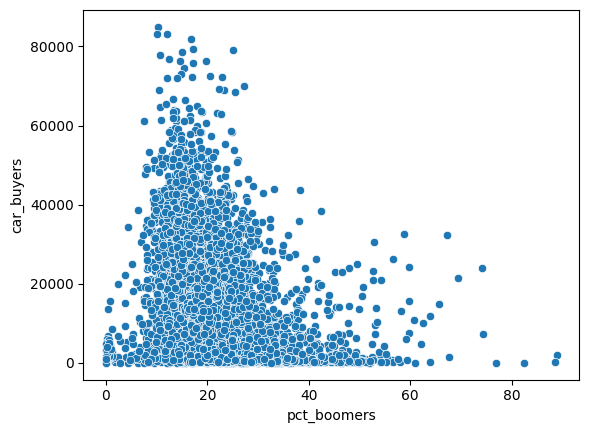

In [237]:
sns.scatterplot(data=df, x='pct_boomers',y='car_buyers')

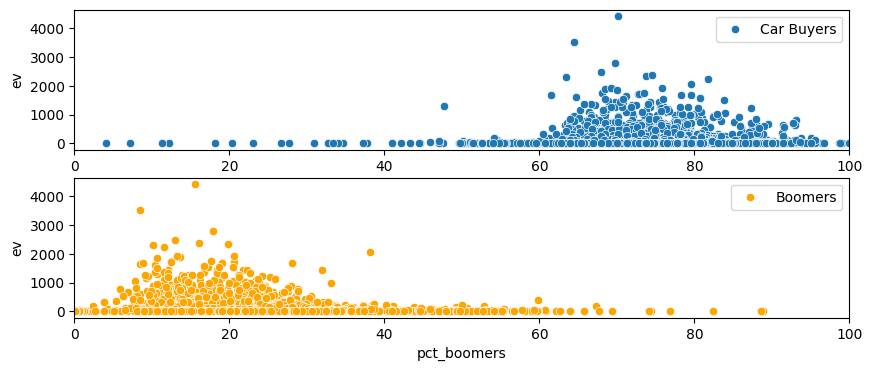

In [238]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))

# Plotting on the first subplot
sns.scatterplot(x=df.pct_car_buyers,y=df.ev, label='Car Buyers',ax=ax1)
ax1.set_xlim(0,100)
ax1.legend()

# Plotting on the second subplot
sns.scatterplot(x=df.pct_boomers,y=df.ev, label='Boomers',ax=ax2,color='orange')
ax2.set_xlim(0,100)
ax2.legend();

<Axes: xlabel='boomers', ylabel='ev_saturation'>

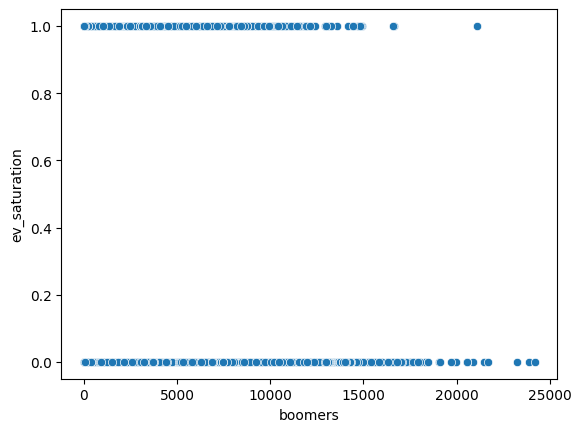

In [239]:
sns.scatterplot(data=df, x='boomers',y='ev_saturation')

In [240]:
# sns.pairplot(df)

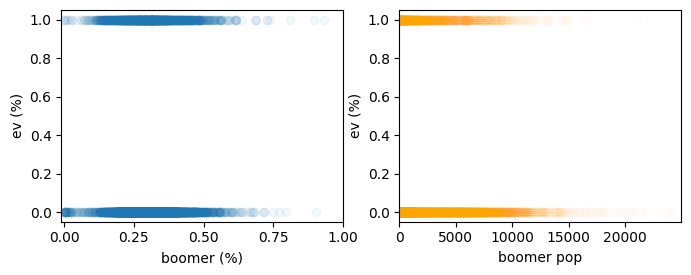

In [244]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,2.75))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
x = df['boomer_saturation'].values
y = df.ev_saturation.values

ax1.scatter(x,y,alpha=.05)
ax1.set_xticks([0,.25,.5,.75,1])
ax1.set_xlim(-.01,1)
ax1.set_xlabel('boomer (%)')
ax1.set_ylabel('ev (%)')

ax2.scatter(df['boomers'],y,alpha=.01,color='orange')
ax2.set_xticks([0,5000,10000,15000,20000])
ax2.set_xlim(-.01,25000)
ax2.set_xlabel('boomer pop')
ax2.set_ylabel('ev (%)');

# BAYES
### PRIOR PREDICTIVE CHECK
### PYMC: 
- https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/posterior_predictive.html

In [282]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [284]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * x
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=x)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


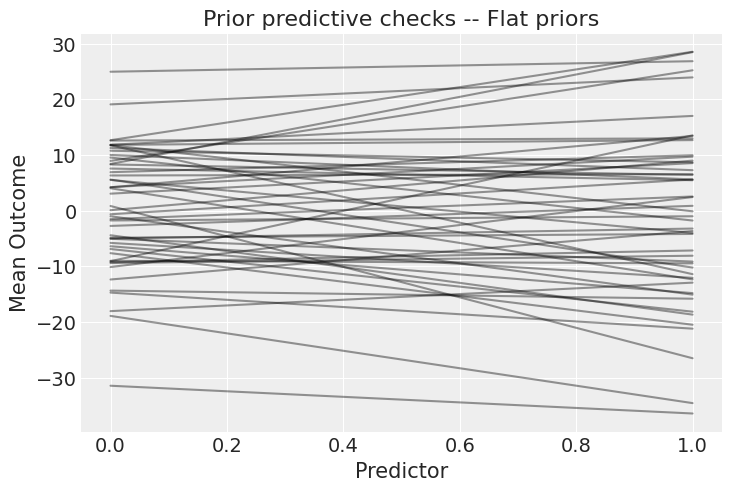

In [287]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(0, 1, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor")
ax.set_ylabel("Mean Outcome")
ax.set_title("Prior predictive checks -- Flat priors");

In [316]:
predictors = np.array(df.boomer_saturation)
outcomes = df.ev_saturation.values

with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.22,0.09,-1.40,-1.05,0.00,0.00,383.81,430.21,1.00
betas[1],0.18,0.29,-0.38,0.70,0.01,0.01,385.43,460.35,1.01


In [317]:
# predictors_out_of_sample = rng.normal(size=50)
# outcomes_out_of_sample = rng.binomial(
#     1, logistic(true_intercept + true_slope * predictors_out_of_sample)
# )

# with model_2:
#     # update values of predictors:
#     pm.set_data({"pred": predictors_out_of_sample})
#     # use the updated values and predict outcomes and probabilities:
#     idata_2 = pm.sample_posterior_predictive(
#         idata_2,
#         var_names=["p"],
#         return_inferencedata=True,
#         predictions=True,
#         extend_inferencedata=True,
#         random_seed=rng,
#     )

Sampling: []


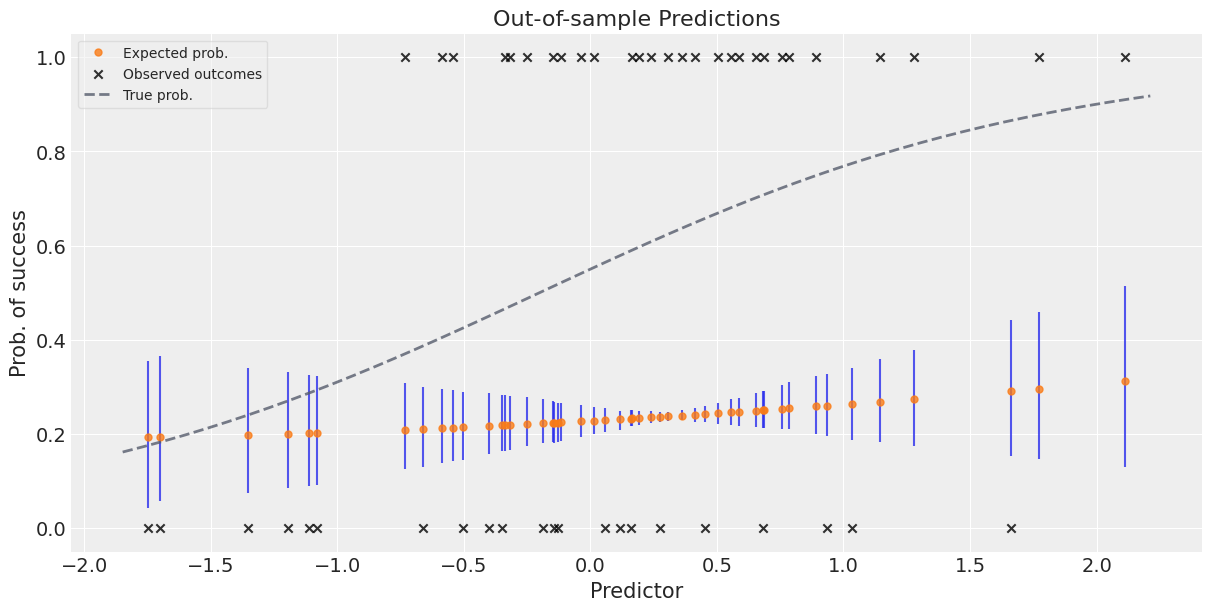

In [318]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [278]:
plt.figure(figsize=(12, 5))
a_s = pm.Normal('alpha',mu=0.0, sigma=1.0)#.sample(1000, tune=1000)
# b_s = pm.Normal(mu=0.0, sigma=0.5).random(size=200)

# for θ_s in zip(logistic(a_s - 3 * b_s), logistic(a_s + 4 * b_s)):
#     plt.plot([-3, 4], θ_s, color="k", alpha=0.2)

# plt.xlabel("Predictor (std)")
# plt.ylabel("Probability of category");

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

<Figure size 1200x500 with 0 Axes>

In [270]:
x = df[['boomer_saturation']]
y = df.ev_saturation.values

with pm.Model() as model_simple:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=-10, sigma=1/0.1)
    mu = alpha + pm.math.dot(x, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    dec_bnd = pm.Deterministic('dec_bnd', -alpha/beta) # decision boundary
    y_1 = pm.Bernoulli('y_1', p=theta, observed=y)
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, beta2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [271]:
import theano.tensor as tt

ModuleNotFoundError: No module named 'theano'

In [58]:
# mod_viz = pm.Model()
# with mod_viz:
#     m_pr = pm.ConstantData("m_prior",0)
#     s_pr = pm.ConstantData("s_prior",1/0.001)
#     alpha = pm.Normal('alpha', mu=m_pr, sigma=s_pr)
#     beta = pm.Normal('beta', mu=m_pr, sigma=s_pr)
#     mu = alpha + pm.math.dot(x, beta)
#     theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
#     y_1 = pm.Bernoulli('y_1', p=theta, observed=y)

# pm.model_to_graphviz(mod_viz)

In [250]:
posterior = trace.posterior.stack(sample=['chain', 'draw'])
alpha_samples = posterior.alpha.values #trace.get_values('alpha')
beta_samples = posterior.beta.values  #trace.get_values('beta')
print(len(alpha_samples), alpha_samples.shape)
print(len(beta_samples), beta_samples.shape)

2000 (2000,)
2000 (2000,)


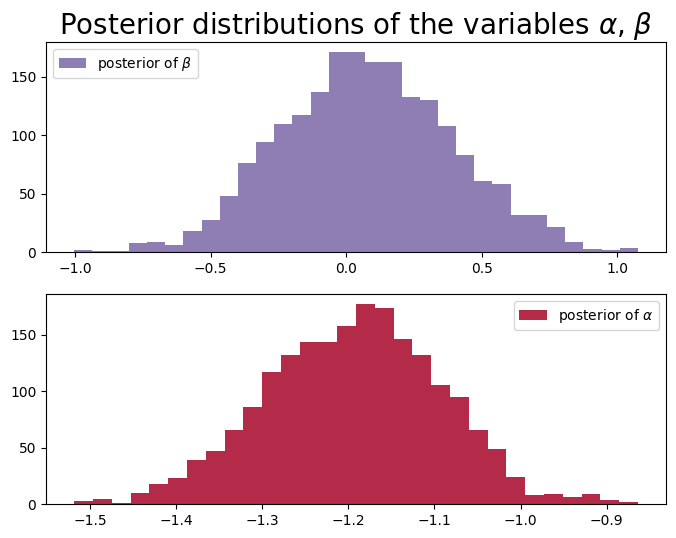

In [251]:
# histogram of the samples:
fig = plt.figure(figsize=(8,6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha$, $\beta$", fontsize=20)
plt.hist(beta_samples, bins='auto',
         histtype='stepfilled', alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6")
plt.legend(loc="upper left")

plt.subplot(212)
plt.hist(alpha_samples, bins='auto',
         histtype='stepfilled', alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628")
plt.legend();

In [252]:
def logistic(x, alpha, beta):
    return 1.0 / ( 1.0 + np.exp(-(alpha + np.dot(beta, x))) )

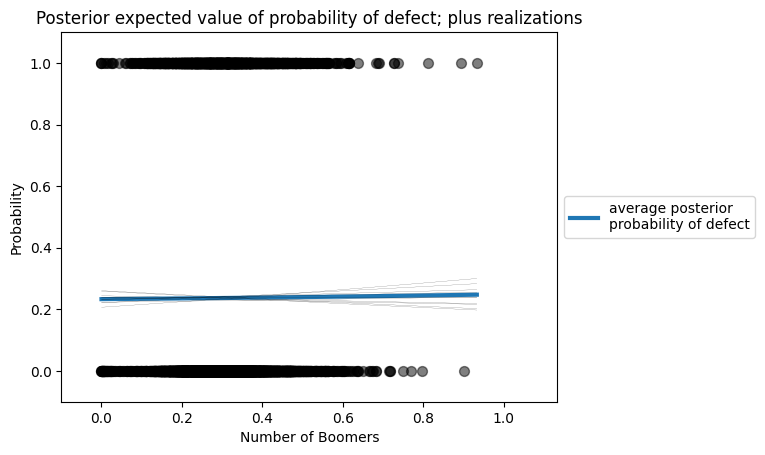

In [253]:
t = np.linspace(0,max(df.boomer_saturation))[:, None]
# t = np.linspace(0,max(df.boomer_saturation)+.1, 50)[:, None]

# all logistic curves in a big matrix:
p_t = logistic(t.T, alpha_samples[:, None], beta_samples[:, None])

# the average probability at each time:
mean_prob_t = p_t.mean(axis=0)
plt.plot(t, mean_prob_t, lw=3, label="average posterior\nprobability of defect")
# plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
# plt.plot(t, p_t[i, :], ls="--", label="realization from posterior")

for i in range(10):
#     plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
    plt.plot(t, p_t[i*10, :],color='black',linewidth=.1)

plt.scatter(df.boomer_saturation, df.ev_saturation, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-0.1, 1.1)
plt.xlim(-.1, t.max()+.2)
plt.ylabel("Probability")
plt.xlabel("Number of Boomers");

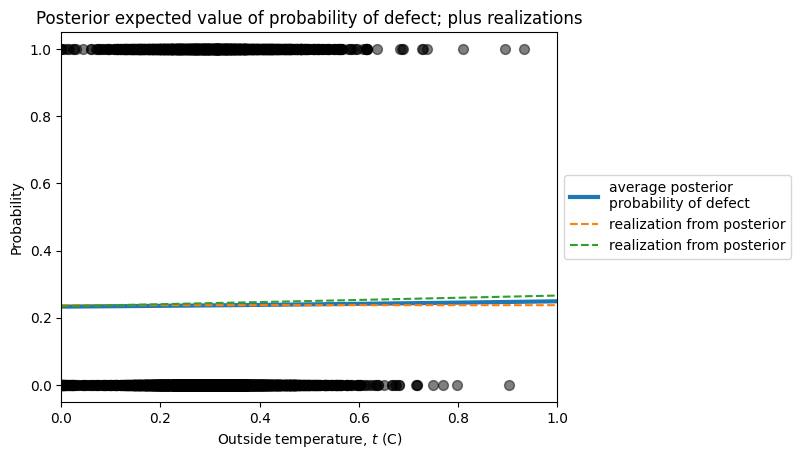

In [254]:
t = np.linspace(0,1, 50)[:, None]
# all logistic curves in a big matrix:
p_t = logistic(t.T, alpha_samples[:, None], beta_samples[:, None])
# the average probability at each time:
mean_prob_t = p_t.mean(axis=0)
plt.plot(t, mean_prob_t, lw=3, label="average posterior\nprobability of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[9, :], ls="--", label="realization from posterior")

plt.scatter(x, y, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel(r"Outside temperature, $t$ (C)");

In [478]:
# LOGISTIC REGRESSION
def logistic(x, alpha, beta):
    return 1.0 / ( 1.0 + np.exp(-(alpha + np.dot(beta, x))) )
# note the np.dot, we're doing many curves at once using some matrix

In [ ]:
# Think about metric...
# EV % per age
# EVs per life years = sum(EVs) / accumulated life-years

# get census data